개요
- 어휘 수가많아지면 계산량도 커진다는 문제
- Embedding
- Negative Sampling

# 4.1 word2vec 개선
- ![fig 4-2.png](<attachment:fig 4-2.png>)
- 두 계산이 병목됨
  - 입력층의 원핫 표현과 가중치 행렬 $W_{in}$의 곱 계산
    - Embedding 계층을 도입하는 것으로 해결
  - 은닉층과 가중치 행렬 $W_{out}$의 곱 및 Softmax 계층의 계산
    - Negative Sampling이라는 새로운 손실 함수를 도입해 해결
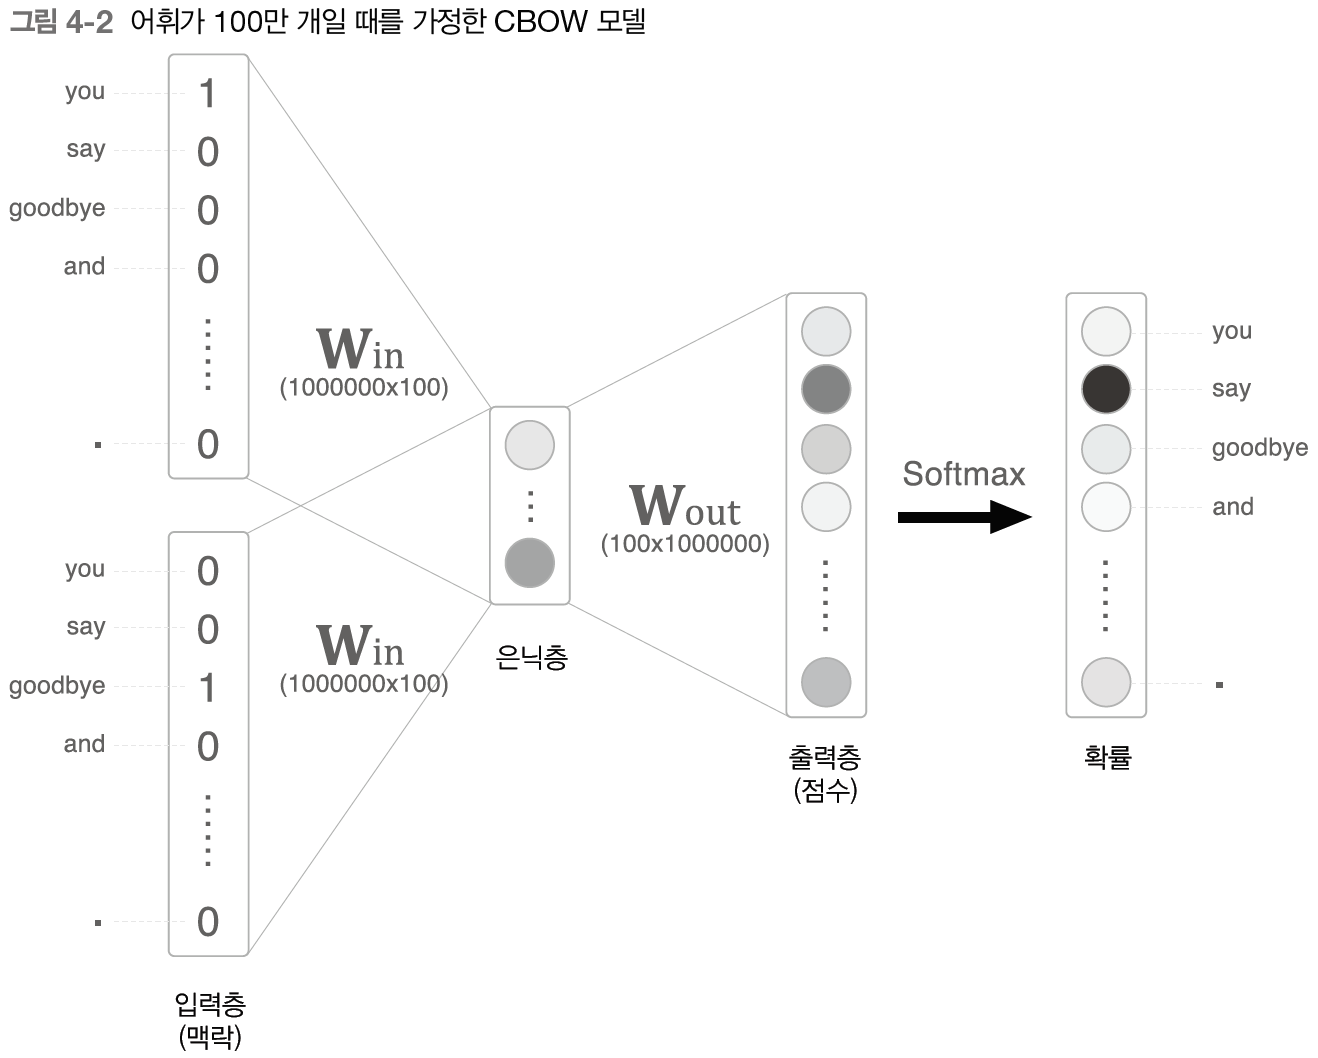

## 4.1.1 Embedding 계층
- 단지 특정 행을 추출하는 거 뿐. 행렬 곱 계산을 사실 필요없음
- 단어 ID에 해당하는 행(벡터)을 추출하는 계층
- Embedding이란 word embedding이라는 용어에서 유래
- Embedding 계층에 word embedding(분산 표현)을 저장하는 것
- 단어의 밀집벡터 표현
  - word embedding
  - distributed representation (신경망 추론 기반)
  - distributional representation (통계 추론 기반)


## 4.1.2 Embedding 계층 구현

In [1]:
import numpy as np

W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

Embedding
![fig 4-4.png](<attachment:fig 4-4.png>)
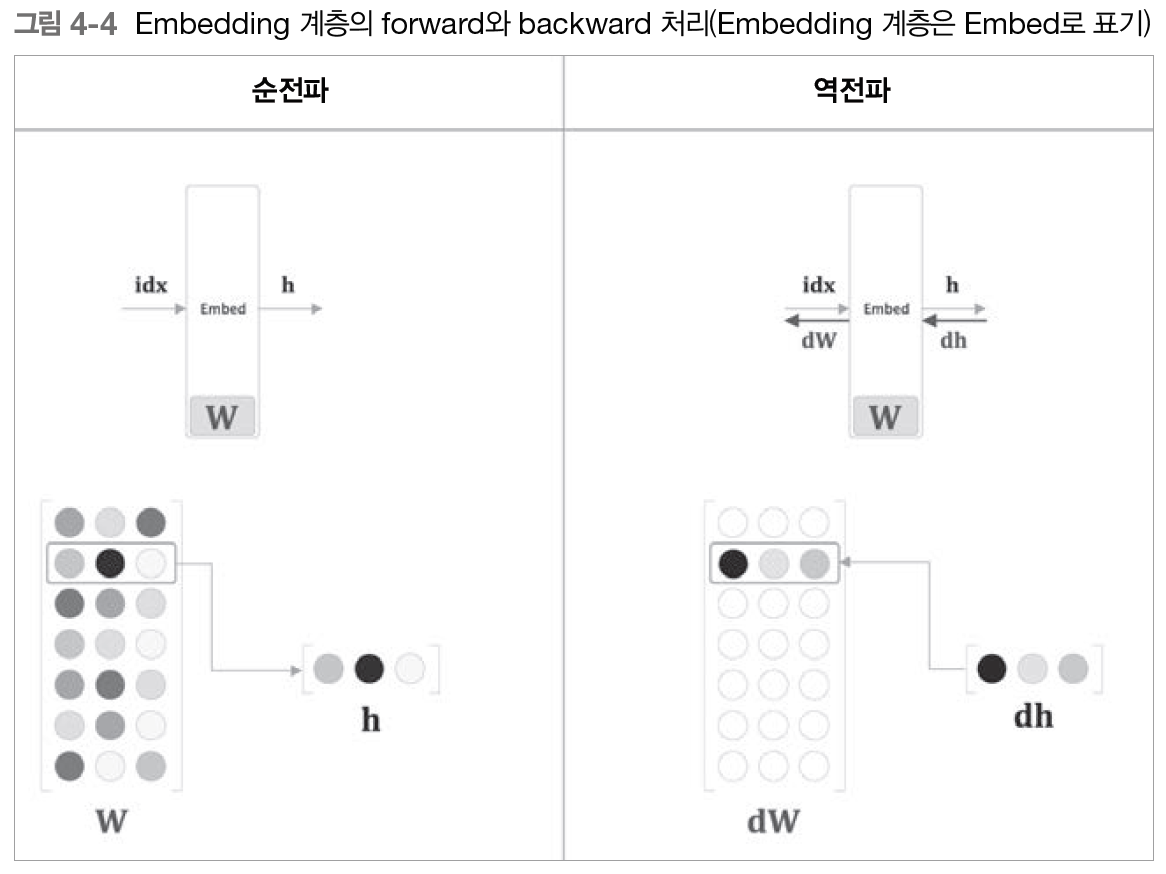

In [ ]:
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
    
  def forward(self, idx):
    W, = self.params
    self.idx = idx
    out = W[idx]
    return out
  
  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    
    # for i, word_id in enumerate(self.idx):
    #   dW[word_id] += dout[i]
    np.add.at(dW, self.idx, dout) # 이게 더 빠름
    
    return None

# 4.2 word2vec 개선

## 4.2.1 은닉층 이후 계산의 문제점
- 은닉층의 뉴런과 가중치 행렬($W_{out}$)의 곱
- Softmax 계층의 계산
  - $y_k = \frac{exp(s_k)}{\sum_{i=1}^{1000000} exp(s_i)}$ 

## 4.2.2 다중 분류에서 이진 분류로
- 다중 분류를 이진 분류로 근사하는 것
- 맥락이 'you'와 'goodbye'일 때 타깃 단어는 'say'입니까?
- ![fig 4-7.png](<attachment:fig 4-7.png>)
- ![fig 4-8.png](<attachment:fig 4-8.png>)
- 이전까지의 출력층에서는 모든 단어를 대상으로 계산을 수행했지만
- 여기서는 'say'라는 단어 하나에 주목하여 그 점수만을 계산하는게 차이
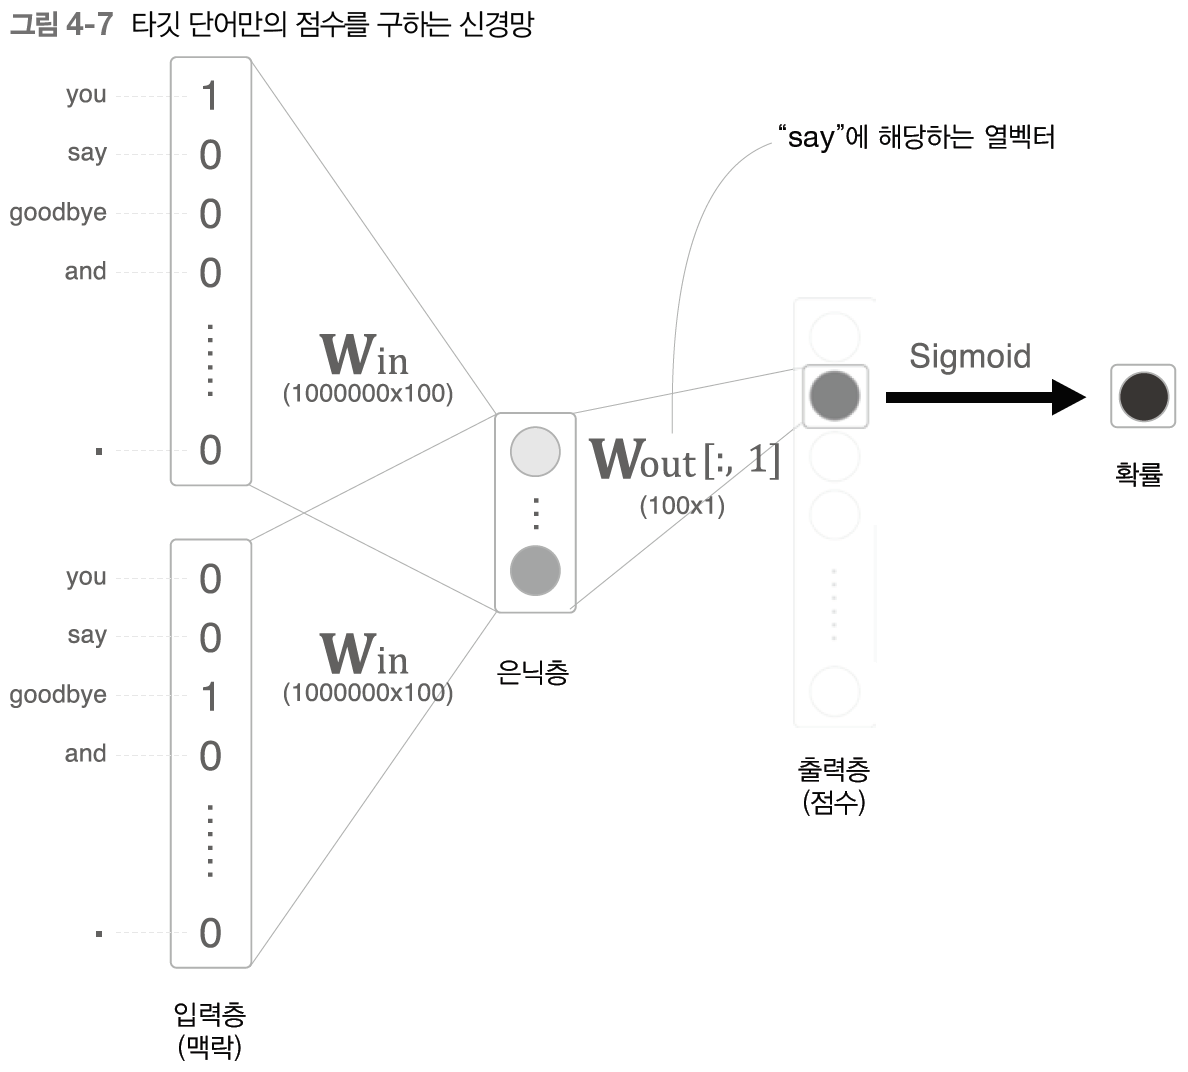
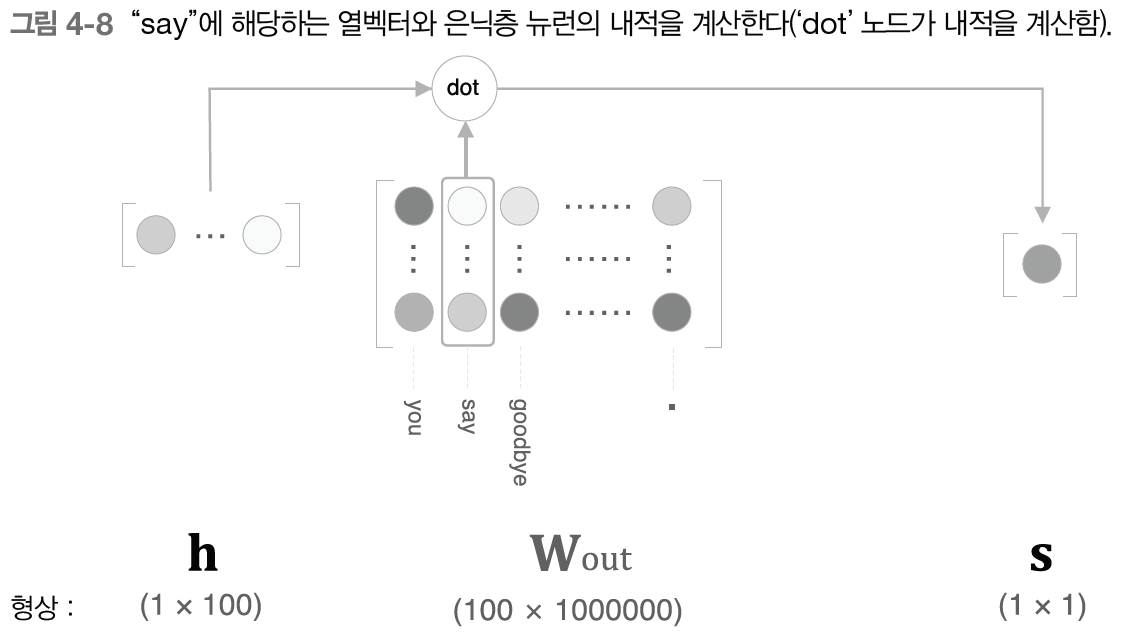

## 4.2.3 시그모이드 함수와 교차 엔트로피 오차
- 이진분류 , 시그모이드 + 교차 엔트로피 
- 다중분류, 소프트맥스 + 교차 엔트로피
- $L = -(tlogy + (1-t)log(1-y))$
- $\frac{\partial L}{\partial x} = y - t$

## 4.2.4 다중분류에서 이진 분류로 (구현)
![fig 4-12.png](<attachment:fig 4-12.png>)
![fig 4-13.png](<attachment:fig 4-13.png>)
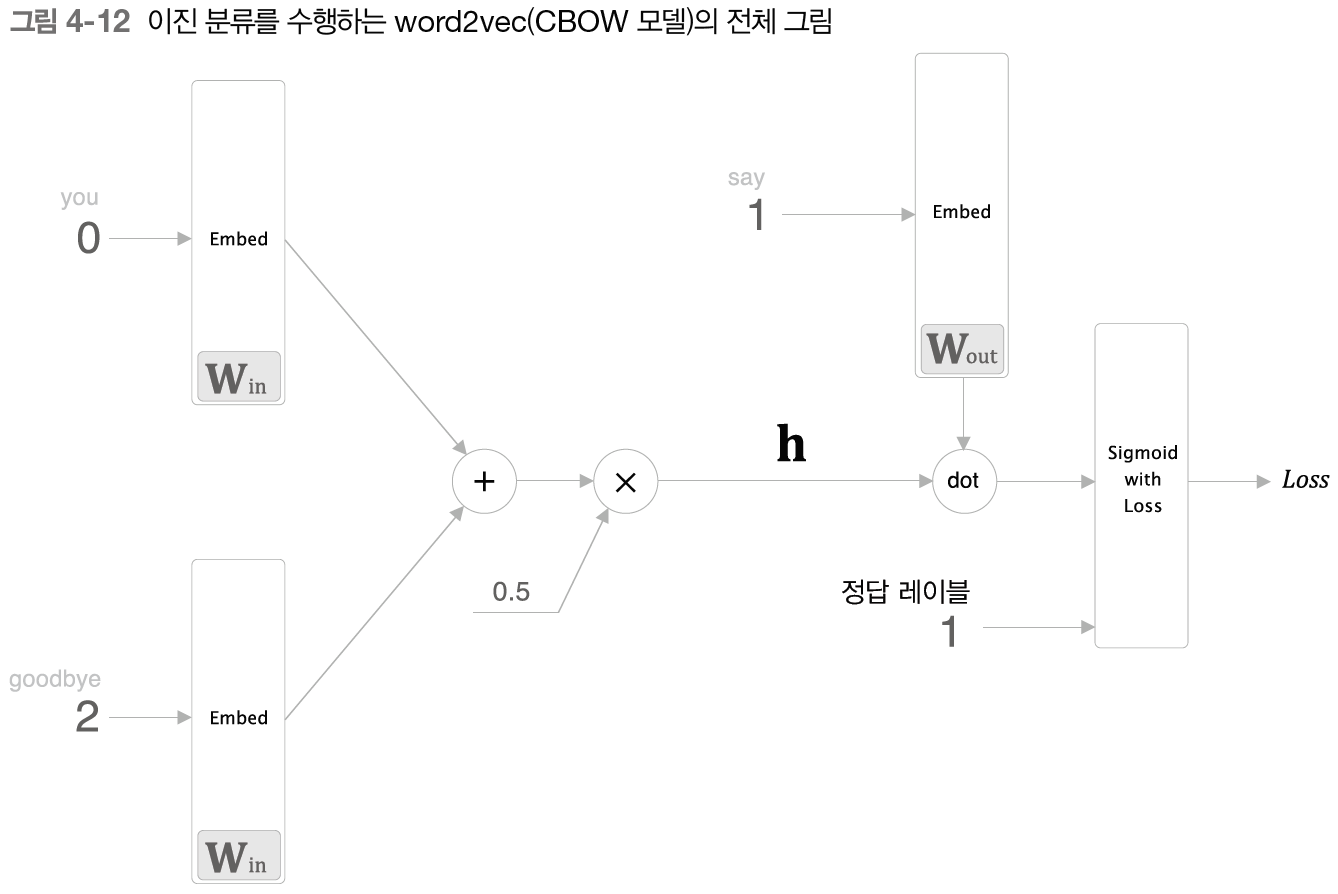
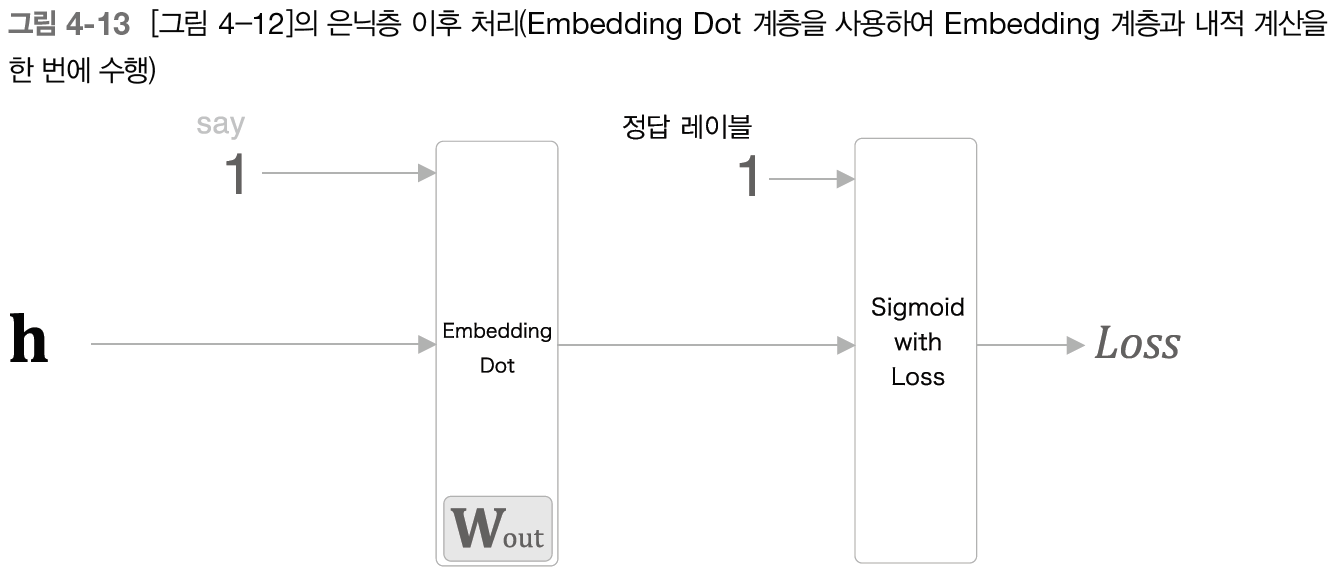

In [ ]:
class EmbeddingDot:
  def __init__(self, W):
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.gradas = self.embed.grads
    self.cache = None
    
  def forward(self, h, idx):
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis=1)
    
    self.cache = (h, target_W)
    return out
  
  def backward(self, dout):
    h, target_W = self.cache
    
    dout = dout.reshape(dout.shape[0], 1)
    
    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

In [22]:
W = np.array([[0, 1, 2],
              [3, 4, 5],
              [6, 7, 8],
              [9, 10, 11],
              [12, 13, 14],
              [15, 16, 17],
              [18, 19, 20]])
idx = [0, 3, 1]
target_W = W[idx]
h = np.array([[0, 1, 2], 
              [3, 4, 5],
              [6, 7, 8]])

## 4.2.5 네거티브 샘플링
- 지금까지는 긍정적인 예(정답)에 대해서만 학습했기 때문에
![fig 4-16.png](<attachment:fig 4-16.png>)
- 다중 분류 문제를 이진 분류로 다루려면 정답과 오답 각각에 대해 바르게 분류할 수 있어야 함
- "적은 수의 부정적 예를 샘플링해 사용" ( 다 쓰면 어휘 수가 증가함에 따라 부담됨)
- 네거티브 샘플링 기법이 의미하는 바
![fig 4-17.png](<attachment:fig 4-17.png>)
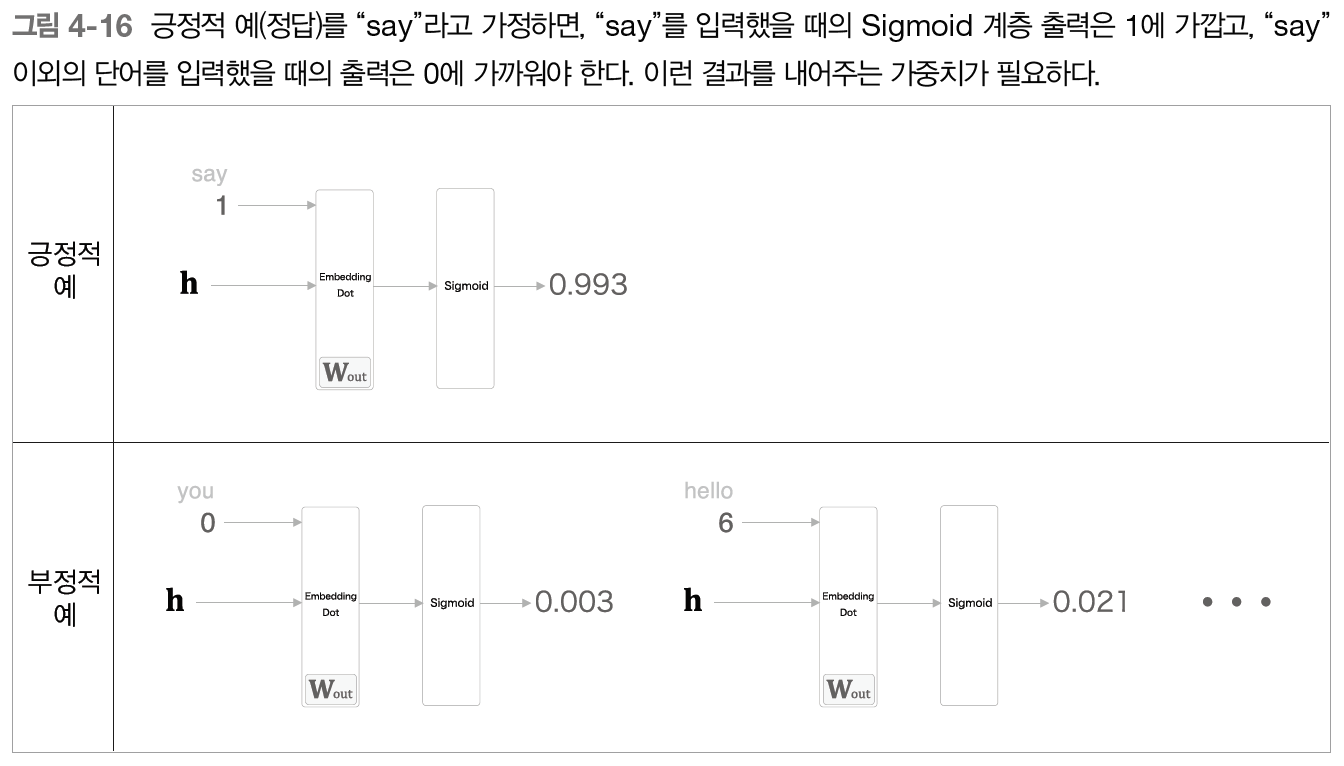
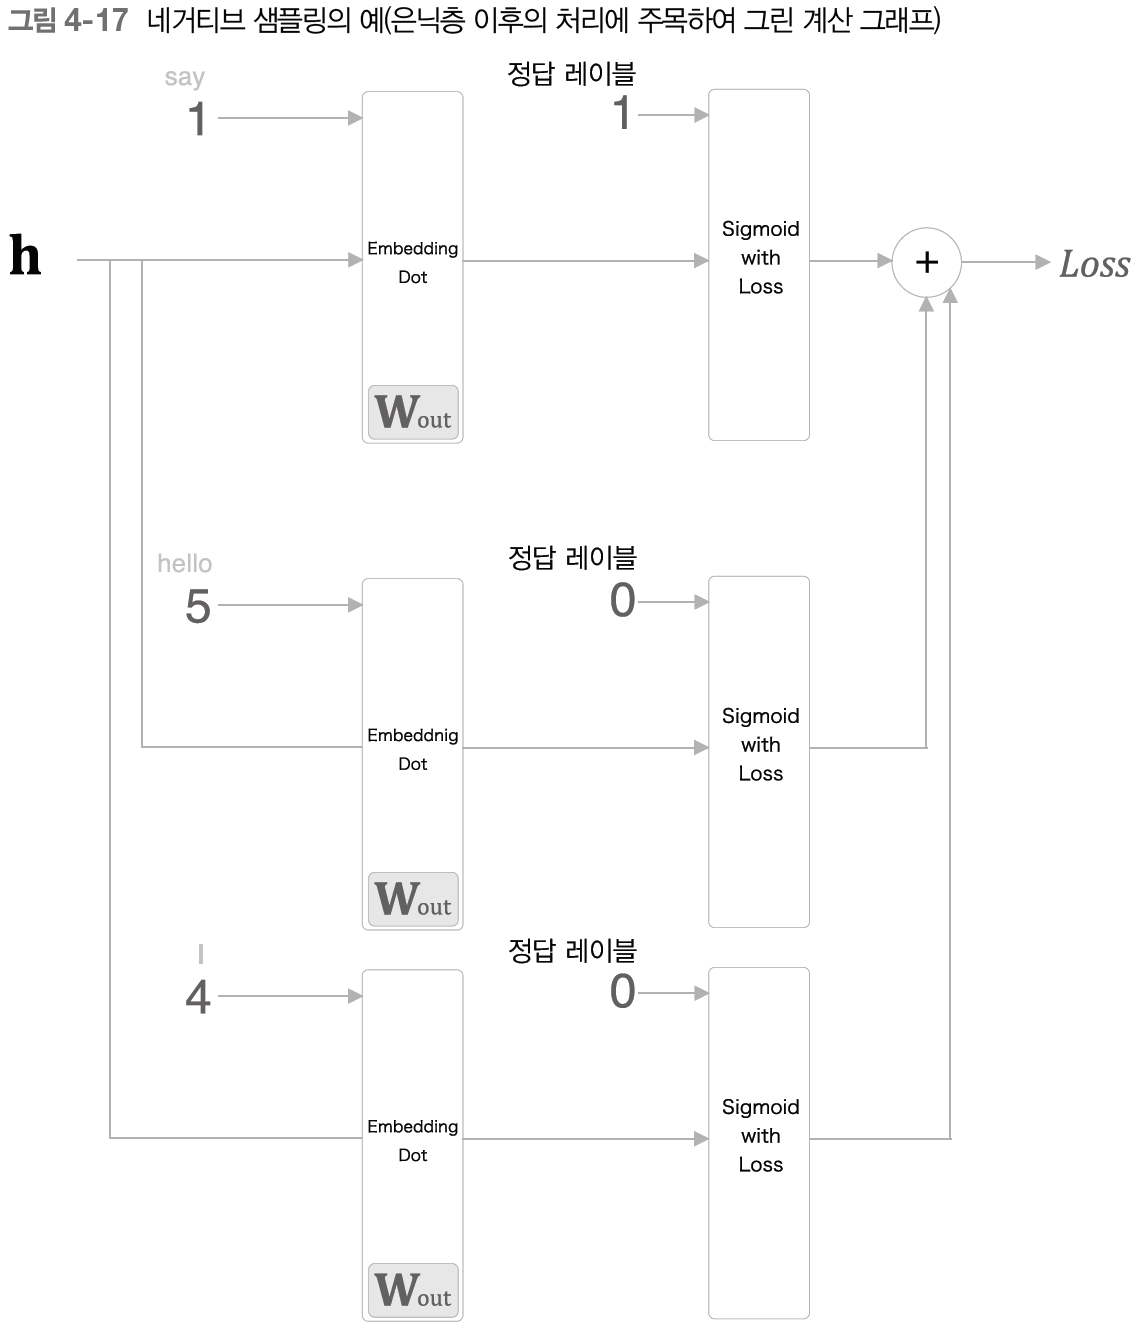

## 4.2.6 네거티브 샘플링의 샘플링 기법
- 말뭉치의 통계 데이터를 기초로 샘플링하는 기법
- ![fig 4-18.png](<attachment:fig 4-18.png>)
- 기본 확률분포에 0.75를 제곱하기를 권고. 출현 확률이 낮은 단어를 버리지 않기 위해서
- $P'(w_i) = \frac{P(w_i)^{0.75}}{\sum_j^n P(w_j)^{0.75}}$
- 부정적인 예를 많이 다루면 좋지만 계산량 문제 때문에 한정
- 희소한 단어만 골라짐 -> 나쁜 결과. 실전 문제에서도 거의 출현하지 않기 때문에.
- Unigram, 하나의 연속된 단어를 뜻함.
  - 한 단어를 대상으로 확률분포를 만든다는 의미
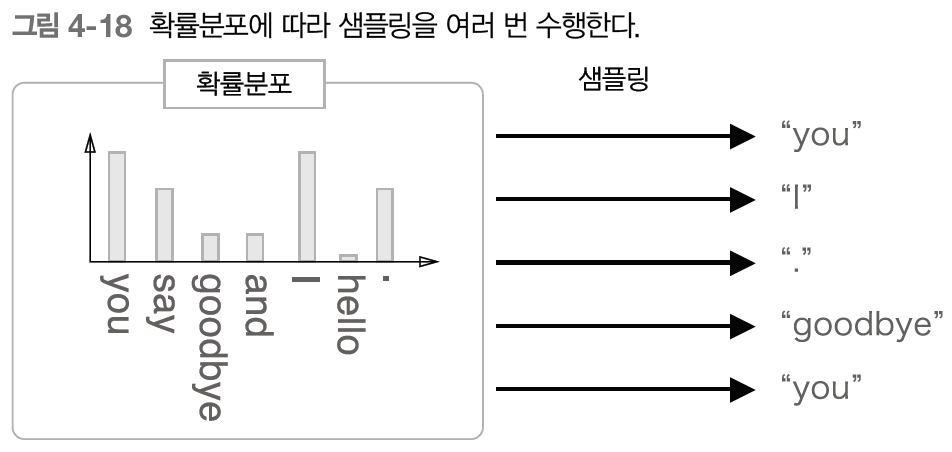

In [44]:
import sys
sys.path.append('../../modules/Part2/')
from negative_sampling import UnigramSampler
from common.layers import *

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[4, 3],
       [0, 1],
       [1, 2]])

## 4.2.7 네거티브 샘플링 구현

In [45]:
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5):
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] 
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads
    
  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)
    
    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype=np.int32)
    loss = self.loss_layers[0].forward(score, correct_label)
    
    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, np.int32)
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i]
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label)
      
    return loss
  
  def backward(self, dout=1):
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)
      
    return dh 

# 4.3 개선판 word2vec 학습

## 4.3.1 CBOW 모델 구현

In [1]:
import sys
sys.path.append('../../modules/Part2/')
import numpy as np
from common.layers import Embedding
from negative_sampling import NegativeSamplingLoss

class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    V, H = vocab_size, hidden_size
    
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')
    
    # 계층 생성
    self.in_layers = []
    for i in range(2 * window_size):
      layer = Embedding(W_in)
      self.in_layers.append(layer)
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
    
    # 모든 가중치와 기울기를 배열에 모은다
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
      
    # 인스턴스 변수에 단어의 분산 표현을 저장
    self.word_vecs = W_in
    
  def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1 / len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    
    return loss
    
  def backward(self, dout=1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

## 4.3.2 CBOW 모델 학습 코드

In [ ]:
import sys
sys.path.append('../../modules/Part2/')
import numpy as np
from common import config
# config.GPU = True
import pickle
from common.tainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# set hyperparameter
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# read data
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)
  
# create model, optimizer, trainer
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# start train
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# save
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word

pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
  pickle.dump(params, f, -1)

## 4.3.3 CBOW 모델 평가

In [8]:
import sys
sys.path.append('../../modules/Part2/')
from common.util import most_similar
import pickle

pkl_file = '../../../data/pickles/cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


유추 문제 (비유 문제)
- 벡터의 덧셈 뺼셈으로 풀 수 있음
- ![fig 4-20.png](<attachment:fig 4-20.png>)
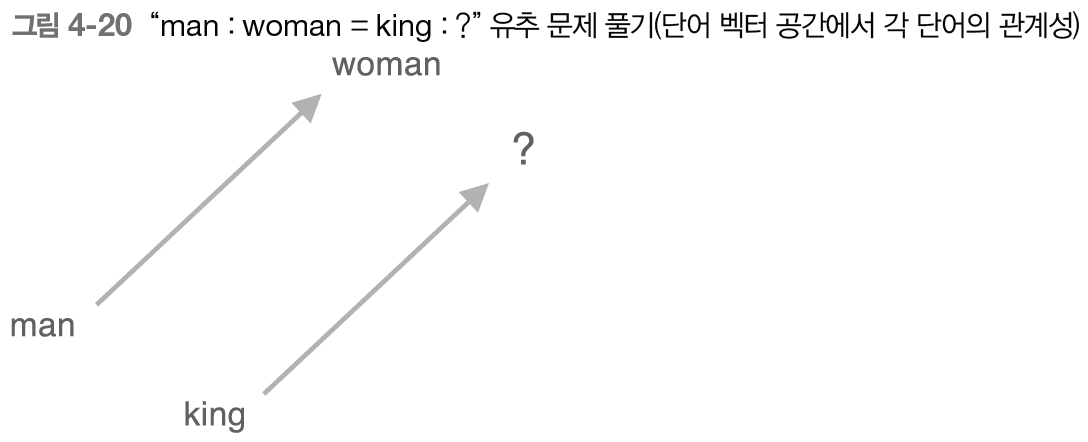

In [10]:
from common.util import analogy
# vec('woman') - vec('man') = vec(?) - vec('king')
# vec('woman') + vec('king') - vec('man') = vec(?) 
tests = [('king', 'man', 'queen'), ('take', 'took', 'go'), ('car', 'cars', 'child'), ('good', 'better', 'bad')]

for test in tests:
  analogy(test[0], test[1], test[2], word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875


# 4.4 word2vec 남은 주제

## 4.4.1 word2vec을 사용한 애플리케이션의 예

전이학습 (transfer learing)
- 한 분야에서 배운 지식을 다른 분야에도 적용하는 기법
- 큰 말뭉치(위키백과나 구글 뉴스의 텍스트 데이터 등)로 학습을 끝난 후, 그 분산 표현을 각자의 작업에 이용
- 텍스트 분류, 문서 클러스터링, 품사 태그 달기, 감정 분석 등 자연어 -> 벡터로 변환해야할 때 분산표현을 이용
- 단어를 고정 길이 벡터로 변환해준다는 장점
- 문장(단어의 흐름)도 단어의 분산 표현을 사용해 고정 길이 벡터로 변환 가능
- 문장의 각 단어를 분산 표현으로 변환하고 그 합을 구하는 것 (bag-of-words)
- 단어->벡터로 변환. 머신러닝 기법들 적용가능
  ![fig 4-21.png](<attachment:fig 4-21.png>)
- 메일을 자동으로 분류하는 시스템
 ![fig 4-22.png](<attachment:fig 4-22.png>)
  - 데이터 수집
  - 수동으로 레이블 붙임
  - word2vec을 이용해 메일을 벡터로 변환
  - 감정 분석을 수행하는 어떤 분류 시스템(SVM, 신경망 등)에 벡터화된 메일과 감정 레이블을 입력하여 학습을 수행
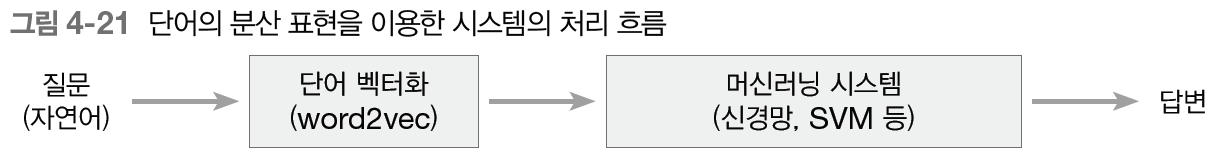
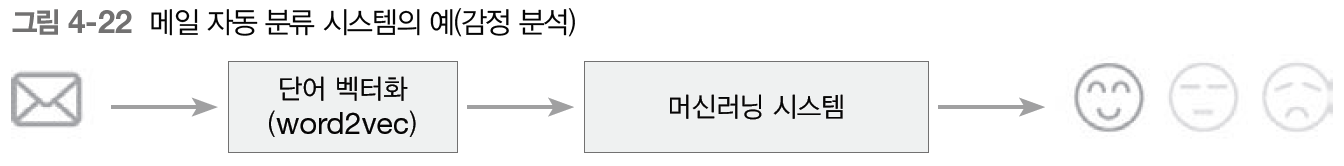

## 4.4.2 단어 벡터 평가방법
- 단어의 분산 표현의 우수성을 실제 애플리케이션과는 분리해 평가하는 것이 일반적
  - 유사성, 유추문제
  
![fig 4-23.png](<attachment:fig 4-23.png>)
- 의미 : 단어의 의미를 유추하는 유추 문제의 정답률
  - king : queen = actor : actree
- 구문 : 단어의 형태 정보를 묻는 문제
  - bad : worst = good : best

- 단어의 분산 표현의 우수함이 애플리케이션에 얼마나 기여하는지 (혹은 기여하지 않는지)는 애플리케이션 종류나 말뭉치의 내용 등, 다루는 문제 상황에 따라 다르다.
- 즉, 유추 문제에 대한 평가가 높다고 해서 애플리케이션에서도 반드시 좋은 결과가 나오리라는 보장은 없다
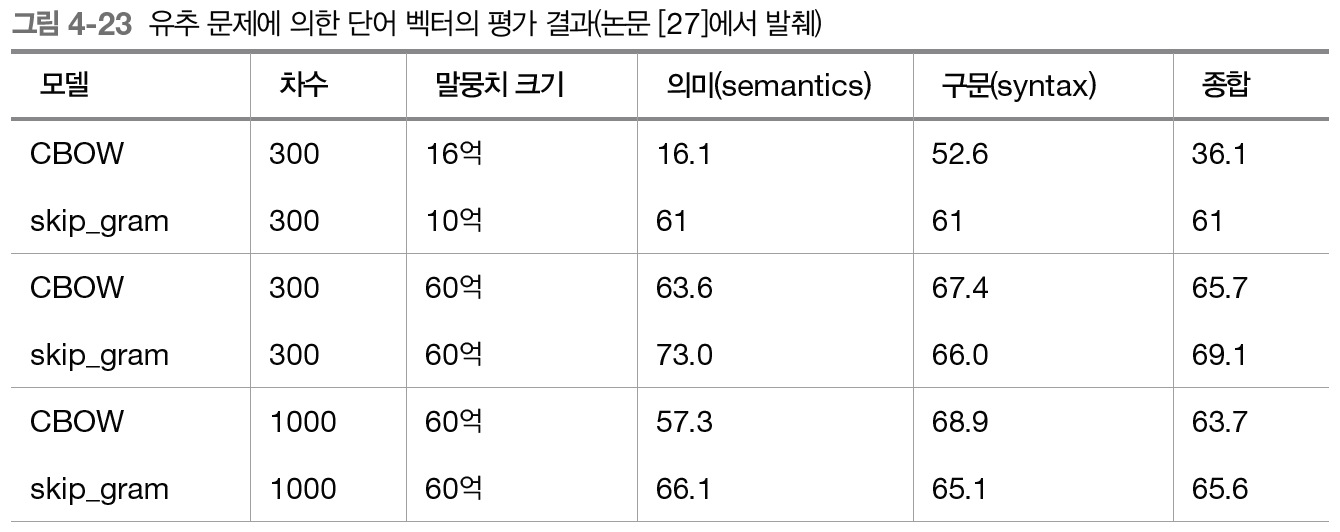